<a href="https://colab.research.google.com/github/HarlinLee/BlobOT/blob/main/loss_contour.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')
DRIVE_PATH = "/content/drive/MyDrive/BlobOT-final"

import sys
sys.path.insert(0, DRIVE_PATH)

import numpy as np
import matplotlib.pyplot as plt

import torch

import datetime
date = datetime.datetime.today().strftime("%y%m%d")
print(date)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
230623


In [2]:
from BlobOT import KE, NLE_pos
from BlobOT import draw_straight_lines

def get_obj_from_y(y, z, params):
  X = draw_straight_lines(z, y, num=params['L']+1)
  X = torch.Tensor(X)
  obj = KE(X, z_tensor, params) + NLE_pos(X, w_tensor, params)

  return obj.numpy()[()]

{'N': 2, 'd': 1, 'dt': 1, 'L': 1, 'delta': 0.1, 'eps': 0.01}
1.0 1.25 398.94302
{'N': 2, 'd': 1, 'dt': 1, 'L': 1, 'delta': 0.1, 'eps': 0.1}
1.0 1.25 39.894302
{'N': 2, 'd': 1, 'dt': 1, 'L': 1, 'delta': 1, 'eps': 0.01}
1.0 1.2499924 26.824535
{'N': 2, 'd': 1, 'dt': 1, 'L': 1, 'delta': 1, 'eps': 0.1}
1.0 1.2499995 2.6824536


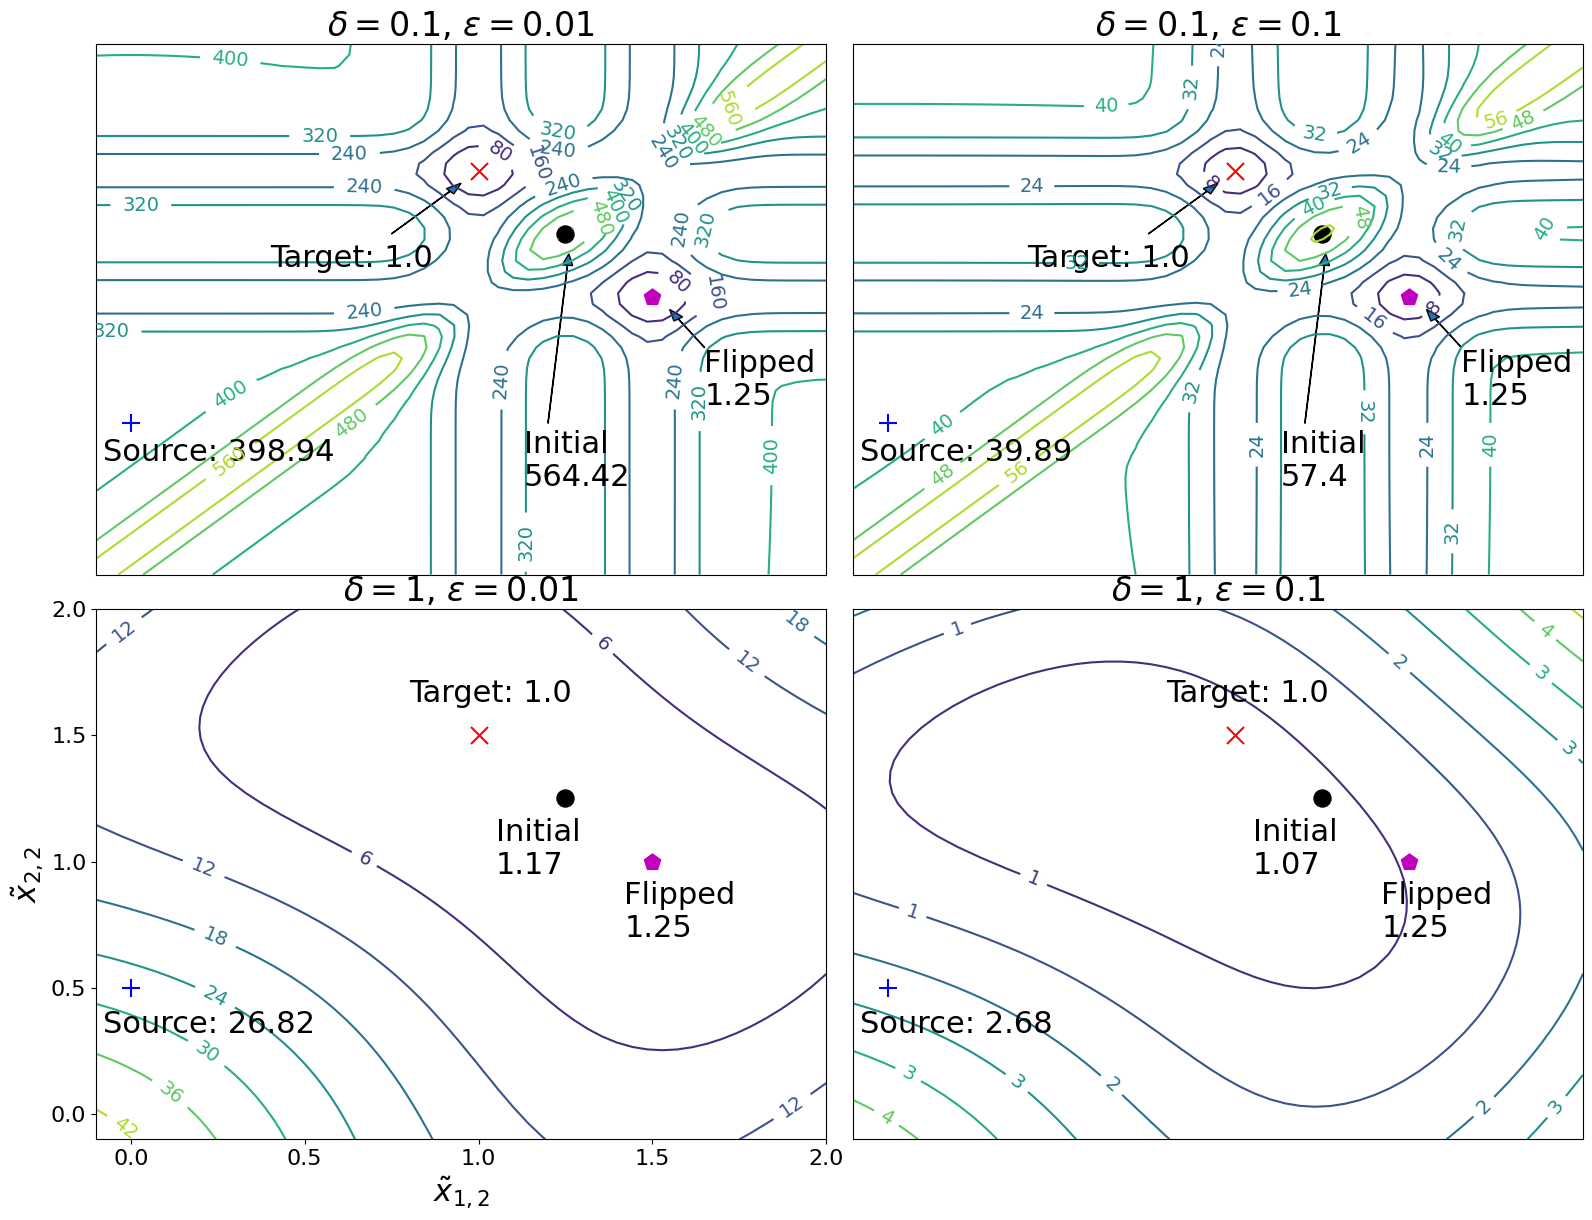

In [3]:
N = 2
d = 1
dt = 1

L = int(1/dt)

nx = 50
ny = 50

params = {'N': N, 'd': d, 'dt': dt, 'L': L}

z = np.array([0, 0.5]).reshape(-1, 1)
w = 1 + z

w_tensor = torch.Tensor(w)
z_tensor = torch.Tensor(z)

fig, axes = plt.subplots(2, 2, figsize=(8*2, 6*2))

for row, delta in enumerate([0.1, 1]):
  for col, epsilon in enumerate([0.01, 0.1]):
    params['delta'] = delta
    params['eps'] = epsilon
    print(params)

    # calculate obj values for meshgrid
    y1s, y2s = np.meshgrid(np.linspace(-0.1, 2, nx), np.linspace(-0.1, 2, ny), indexing='ij')
    dats = np.zeros((nx, ny))

    for i in range(nx):
      for j in range(ny):
        c = np.array([y1s[i, j], y2s[i, j]]).reshape(-1, 1)
        dats[i, j] = get_obj_from_y(c, z, params)

    # calculate obj values for key points
    w_score = get_obj_from_y(w, z, params)
    wflip_score = get_obj_from_y(np.flip(w), z, params)
    z_score = get_obj_from_y(z, z, params)

    y0 = np.tile(w.mean(axis=0), [N, 1])
    y0_score = get_obj_from_y(y0, z, params)

    print(w_score, wflip_score, z_score)

    # do all plotting
    ax = axes[row, col]

    CS = ax.contour(y1s, y2s, dats)
    ax.clabel(CS, inline=True, fontsize=14, fmt='%d')

    ax.scatter(w[0], w[1], c='r', marker='x', s=150)
    ax.scatter(w[1], w[0], c='m', marker='p', s=150)
    ax.scatter(y0[0], y0[1], c='k', marker='o', s=150)
    ax.scatter(z[0], z[1], c='b', marker='+', s=150)

    if delta > 0.1:
      ax.text(w[0]-0.2, w[1]+0.13, 'Target: '+str(np.round(w_score, 2)), fontsize=22)
      ax.text(w[1]-0.08, w[0]-0.3, 'Flipped \n'+ str(np.round(wflip_score, 2)), fontsize=22)
      ax.text(y0[0]-0.2, y0[1]-0.3,'Initial \n'+ str(np.round(y0_score, 2)), fontsize=22)
      ax.text(z[0]-0.08, z[1]-0.18, 'Source: '+str(np.round(z_score, 2)), fontsize=22)
    else:
      ax.text(w[0]-0.6, w[1]-0.38, 'Target: '+str(np.round(w_score, 2)), fontsize=22)
      ax.arrow(0.75, 1.25, 0.2, 0.2, length_includes_head=True, head_width=0.03)

      ax.text(1.65, 0.57, 'Flipped \n'+str(np.round(wflip_score, 2)), fontsize=22)
      ax.arrow(1.65, 0.8, -0.1, 0.15, length_includes_head=True, head_width=0.03)

      ax.text(1.13, 0.25,'Initial \n'+ str(np.round(y0_score, 2)), fontsize=22)
      ax.arrow(1.2, 0.5, 0.06, 0.67, length_includes_head=True, head_width=0.03)

      ax.text(z[0]-0.08, z[1]-0.15, 'Source: '+str(np.round(z_score, 2)), fontsize=22)

    if row == 1 and col == 0:
      ax.set_xlabel(r'$\tilde{x}_{1, 2}$',fontsize=22)
      ax.set_ylabel(r'$\tilde{x}_{2, 2}$',fontsize=22)

      ax.xaxis.set_ticks([0, 0.5, 1, 1.5, 2])
      ax.yaxis.set_ticks([0, 0.5, 1, 1.5, 2])
      ax.xaxis.set_tick_params(labelsize=16)
      ax.yaxis.set_tick_params(labelsize=16)
    else:
      ax.xaxis.set_ticks([])
      ax.yaxis.set_ticks([])

    ax.set_title('$\delta=$'+str(delta)+', $\epsilon=$'+str(epsilon), fontsize=24)

plt.tight_layout(pad=0)
plt.savefig(os.path.join(DRIVE_PATH, f'loss_contour_{date}.pdf'), dpi=300)
plt.show()